In [1]:
#import necessary libraries

import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  seaborn as sns
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
#importing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/SAC10549/OralCancer'

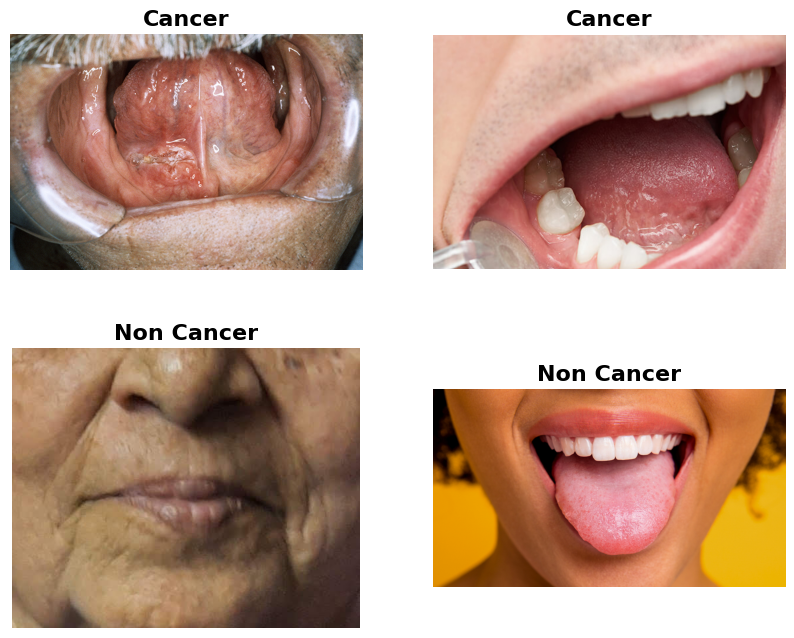

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


cancer_dir = os.path.join(data_dir, 'cancer')
noncancer_dir = os.path.join(data_dir, 'non-cancer')

# Get the list of files in each directory
cancer_files = os.listdir(cancer_dir)[:2]  # Select the first two cancer images
noncancer_files = os.listdir(noncancer_dir)[:2]  # Select the first two noncancer images

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot benign images
for i in range(2):
    img_path = os.path.join(cancer_dir, cancer_files[i])
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title('Cancer',fontsize=16,fontweight='bold')

# Plot malignant images
for i in range(2):
    img_path = os.path.join(noncancer_dir, noncancer_files[i])
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title('Non Cancer',fontsize=16,fontweight='bold')

plt.show()


In [ ]:
#@title Preprocessing

In [ ]:
import os
import cv2
from tqdm import tqdm

# Create output directories for preprocessed images
output_dir_cancer = os.path.join(data_dir, 'cancer_preprocessed')
output_dir_non_cancer = os.path.join(data_dir, 'non_cancer_preprocessed')

os.makedirs(output_dir_cancer, exist_ok=True)
os.makedirs(output_dir_non_cancer, exist_ok=True)

# Function to preprocess images
def preprocess_images(input_dir, output_dir):
    for filename in tqdm(os.listdir(input_dir)):
        if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are in jpg or png format
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            # Read the image
            image = cv2.imread(input_path)

            # Resize the image to your desired size (e.g., 224*224)
            resized_image = cv2.resize(image, (224, 224))

            # Convert the image to YUV color space
            yuv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YUV)

            # Apply contrast adjustment to the luminance channel
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            yuv_image[:,:,0] = clahe.apply(yuv_image[:,:,0])

            # Convert the image back to BGR color space
            enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR)

            # Save the preprocessed image
            cv2.imwrite(output_path, enhanced_image)

# Preprocess cancer images
preprocess_images(os.path.join(data_dir, 'cancer'), output_dir_cancer)

# Preprocess non-cancer images
preprocess_images(os.path.join(data_dir, 'non-cancer'), output_dir_non_cancer)


100%|██████████| 44/44 [00:17<00:00,  2.48it/s]


In [ ]:
#@title Segmentation

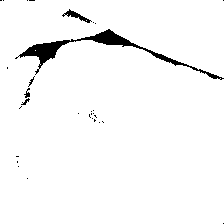

In [ ]:
#Segmentation with one image
import cv2
import numpy as np
from skimage import morphology, segmentation
from google.colab.patches import cv2_imshow
# Firefly Algorithm
def firefly_algorithm(objective_function, search_space, n_fireflies=20, max_generations=50, alpha=0.2, beta_min=0.2, gamma=1.0):
    fireflies = np.random.uniform(low=search_space[0][0], high=search_space[0][1], size=(n_fireflies,))

    for generation in range(max_generations):
        fitness = [objective_function(firefly) for firefly in fireflies]

        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[i] < fitness[j]:
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta_min + (1 - beta_min) * np.exp(-gamma * distance**2)
                    fireflies[i] = fireflies[i] + alpha * (beta * (fireflies[j] - fireflies[i])) + np.random.normal(scale=0.1)

    best_firefly = fireflies[np.argmin(fitness)]
    return best_firefly

# Watershed Transformation
def watershed_transform(image, threshold):
    thresholded_image = (image > threshold).astype(np.uint8)
    markers = morphology.label(thresholded_image)
    segmented_image = segmentation.watershed(-image, markers, mask=thresholded_image)
    return segmented_image

# Whale Optimization Algorithm
def whale_optimization_algorithm(objective_function, initial_parameters, max_generations=50, a=2.0):
    current_parameters = initial_parameters.copy()

    for generation in range(max_generations):
        fitness_current = objective_function(current_parameters)
        a_random = 2 * a * np.random.rand(len(current_parameters)) - a
        current_parameters = current_parameters - a_random * np.abs(current_parameters - current_parameters)

    return current_parameters

# Read your image
image = cv2.imread('/content/drive/My Drive/SAC10549/Preprocessed/cancer_preprocessed/3-s2.0-B9780443100734500148-f10-07-9780443100734.jpg', cv2.IMREAD_GRAYSCALE)

# Firefly Algorithm for threshold optimization
def objective_function_for_firefly(threshold):
    thresholded_image = (image > threshold).astype(np.uint8)
    markers = morphology.label(thresholded_image)
    segmented_image = segmentation.watershed(-image, markers, mask=thresholded_image)
    return -len(np.unique(segmented_image))

# Define the search space for the Firefly Algorithm
search_space_firefly = [(0, 255)]

# Perform Firefly Algorithm optimization for threshold
optimized_threshold = firefly_algorithm(objective_function_for_firefly, search_space_firefly)

# Apply Watershed Transformation using the optimized threshold
segmented_image = watershed_transform(image, optimized_threshold)

# Whale Optimization Algorithm for further refinement
def objective_function_for_whale(parameters):
    return -len(np.unique(segmented_image))

# Initialize parameters for Whale Optimization Algorithm
initial_parameters_whale = np.array([1.0, 1.0])  # Placeholder, replace with actual initialization

# Perform Whale Optimization Algorithm optimization for refinement
refined_parameters = whale_optimization_algorithm(objective_function_for_whale, initial_parameters_whale)

# Display the segmented image
cv2_imshow((segmented_image * 255).astype(np.uint8))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import os
import cv2
import numpy as np
from skimage import morphology, segmentation
from google.colab.patches import cv2_imshow

# Firefly Algorithm
def firefly_algorithm(objective_function, search_space, n_fireflies=20, max_generations=50, alpha=0.2, beta_min=0.2, gamma=1.0):
    fireflies = np.random.uniform(low=search_space[0][0], high=search_space[0][1], size=(n_fireflies,))

    for generation in range(max_generations):
        fitness = [objective_function(firefly) for firefly in fireflies]

        for i in range(n_fireflies):
            for j in range(n_fireflies):
                if fitness[i] < fitness[j]:
                    distance = np.linalg.norm(fireflies[i] - fireflies[j])
                    beta = beta_min + (1 - beta_min) * np.exp(-gamma * distance**2)
                    fireflies[i] = fireflies[i] + alpha * (beta * (fireflies[j] - fireflies[i])) + np.random.normal(scale=0.1)

    best_firefly = fireflies[np.argmin(fitness)]
    return best_firefly

# Watershed Transformation
def watershed_transform(image, threshold):
    thresholded_image = (image > threshold).astype(np.uint8)
    markers = morphology.label(thresholded_image)
    segmented_image = segmentation.watershed(-image, markers, mask=thresholded_image)
    return segmented_image

# Whale Optimization Algorithm
def whale_optimization_algorithm(objective_function, initial_parameters, max_generations=50, a=2.0):
    current_parameters = initial_parameters.copy()

    for generation in range(max_generations):
        fitness_current = objective_function(current_parameters)
        a_random = 2 * a * np.random.rand(len(current_parameters)) - a
        current_parameters = current_parameters - a_random * np.abs(current_parameters - current_parameters)

    return current_parameters

# Read your image
image_dir = '/content/drive/MyDrive/SAC10549/Preprocessed'
output_dir_cancer = '/content/drive/MyDrive/SAC10549/Segmented/cancer_segmented'
outputo_dir_non_cancer = '/content/drive/MyDrive/SAC10549/Segmented/non_cancer_segmented'

# Create output directories if they don't exist
os.makedirs(output_dir_cancer, exist_ok=True)
os.makedirs(output_dir_non_cancer, exist_ok=True)

# Process each image in the cancer preprocessed folder
cancer_dir = os.path.join(image_dir, 'cancer_preprocessed')
for filename in os.listdir(cancer_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # Read the color image
        image_path = os.path.join(cancer_dir, filename)
        image = cv2.imread(image_path)

        # Firefly Algorithm for threshold optimization
        def objective_function_for_firefly(threshold):
            thresholded_image = (image > threshold).astype(np.uint8)
            markers = morphology.label(thresholded_image[:, :, 0])  # Using one channel for markers (you can modify as needed)
            segmented_image = segmentation.watershed(-image[:, :, 0], markers, mask=thresholded_image[:, :, 0])
            return -len(np.unique(segmented_image))

        # Define the search space for the Firefly Algorithm
        search_space_firefly = [(0, 255)]

        # Perform Firefly Algorithm optimization for threshold
        optimized_threshold = firefly_algorithm(objective_function_for_firefly, search_space_firefly)

        # Apply Watershed Transformation using the optimized threshold
        segmented_image = watershed_transform(image[:, :, 0], optimized_threshold)  # Using one channel (you can modify as needed)

        # Perform Whale Optimization Algorithm for further refinement
        def objective_function_for_whale(parameters):
            return -len(np.unique(segmented_image))

        # Initialize parameters for Whale Optimization Algorithm
        initial_parameters_whale = np.array([1.0, 1.0])  # Placeholder, replace with actual initialization

        # Perform Whale Optimization Algorithm optimization for refinement
        refined_parameters = whale_optimization_algorithm(objective_function_for_whale, initial_parameters_whale)

        # Save the segmented image
        output_path = os.path.join(output_dir_cancer, f'segmented_{filename}')
        cv2.imwrite(output_path, (segmented_image * 255).astype(np.uint8))

# Repeat the process for non-cancer images
non_cancer_dir = os.path.join(image_dir, 'non_cancer_preprocessed')
for filename in os.listdir(non_cancer_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(non_cancer_dir, filename)
        image = cv2.imread(image_path)

        optimized_threshold = firefly_algorithm(objective_function_for_firefly, search_space_firefly)
        segmented_image = watershed_transform(image[:, :, 0], optimized_threshold)
        refined_parameters = whale_optimization_algorithm(objective_function_for_whale, initial_parameters_whale)

        output_path = os.path.join(output_dir_non_cancer, f'segmented_{filename}')
        cv2.imwrite(output_path, (segmented_image * 255).astype(np.uint8))


In [ ]:
#@title Feature Extraction and Feature Selection

In [3]:
import os
import cv2
import numpy as np
from skimage import color, feature
from google.colab.patches import cv2_imshow

# Gray level Cooccurence Matrix Feature Extraction
# GLCM Feature Extraction
def glcm_feature_extraction(image):
    gray_image = color.rgb2gray(image)
    gray_image_uint = (gray_image * 255).astype(np.uint8)  # Convert to unsigned integer type
    glcm = feature.graycomatrix(gray_image_uint, [1], [0], symmetric=True, normed=True)
    contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
    correlation = feature.graycoprops(glcm, 'correlation')[0, 0]
    energy = feature.graycoprops(glcm, 'energy')[0, 0]
    homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
    return contrast, correlation, energy, homogeneity

# Chimp Feature Selection Function
def chimp_feature_selection(image, selected_features):
    # Modify this function based on the features you want to select
    # For simplicity, let's assume selected_features is a list of indices to keep from GLCM features
    contrast, correlation, energy, homogeneity = glcm_feature_extraction(image)
    selected_features_values = [contrast, correlation, energy, homogeneity]

    # Keep only the selected features
    selected_values = [selected_features_values[i] for i in selected_features]

    return selected_values

# Chimp optimization function
def initialize_chimp_population(population_size, feature_count):
    return np.random.randint(2, size=(population_size, feature_count))  # Binary encoding for feature selection

def chimp_fitness_function(selected_features, image_dir):
    total_loss = 0

    # Process each image in the preprocessed folder
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path)

            # Get the selected features for Chimp optimization
            selected_values = chimp_feature_selection(image, selected_features)

            # Your custom objective function for Chimp optimization
            # For simplicity, let's use the sum of selected feature values as the objective
            total_loss += sum(selected_values)

    return total_loss

def chimp_algorithm(chimp_fitness_function, population_size, feature_count, iterations, cancer_image_dir, non_cancer_image_dir):
    population = initialize_chimp_population(population_size, feature_count)

    for iteration in range(iterations):
        # Evaluate fitness for cancer images
        fitness_cancer = np.apply_along_axis(chimp_fitness_function, 1, population, image_dir=cancer_image_dir)

        # Evaluate fitness for non-cancer images
        fitness_non_cancer = np.apply_along_axis(chimp_fitness_function, 1, population, image_dir=non_cancer_image_dir)

        # Combine fitness values for both classes
        fitness_values = fitness_cancer + fitness_non_cancer

        sorted_indices = np.argsort(fitness_values)

        best_solution = population[sorted_indices[0]]
        best_fitness = fitness_values[sorted_indices[0]]

        # Update the population based on the best solution
        for i in range(1, population_size):
            rand = np.random.uniform(0, 1, feature_count)
            population[i] = best_solution + rand * (population[i] - best_solution)

        print(f"Iteration {iteration + 1}, Best Fitness: {best_fitness}")

    return best_solution

# Specify the image directories
cancer_image_dir = '/content/drive/MyDrive/SAC10549/Segmented/cancer_segmented'
non_cancer_image_dir = '/content/drive/MyDrive/SAC10549/Segmented/non_cancer_segmented'

# Set other parameters
population_size = 10
feature_count = 4
iterations = 5

# Run the chimp_algorithm
best_solution = chimp_algorithm(chimp_fitness_function, population_size, feature_count, iterations, cancer_image_dir, non_cancer_image_dir)

# Print the final selected features
print("Final Selected Features:", best_solution)


Iteration 1, Best Fitness: 323.01345246256903
Iteration 2, Best Fitness: 323.01345246256903
Iteration 3, Best Fitness: 323.01345246256903
Iteration 4, Best Fitness: 323.01345246256903
Iteration 5, Best Fitness: 323.01345246256903
Final Selected Features: [1 1 1 1]


In [4]:
#@title Model Building

In [5]:
import os
import cv2
import numpy as np
from skimage import color, feature
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LeakyReLU, BatchNormalization, Input

# Function to extract selected features from an image
def extract_selected_features(image_path, selected_features):
    image = cv2.imread(image_path)
    selected_values = chimp_feature_selection(image, selected_features)
    return selected_values

# Function to load data and labels for classification
def load_data_and_labels(image_dir, selected_features):
    data = []
    labels = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            features = extract_selected_features(image_path, selected_features)
            label = 1 if "cancer" in filename.lower() else 0  # Assuming cancer images have "cancer" in their filenames
            data.append(features)
            labels.append(label)

    return np.array(data), np.array(labels)

# Load data and labels for cancer images
cancer_data, cancer_labels = load_data_and_labels(cancer_image_dir, best_solution)

# Load data and labels for non-cancer images
non_cancer_data, non_cancer_labels = load_data_and_labels(non_cancer_image_dir, best_solution)

# Concatenate cancer and non-cancer data
all_data = np.concatenate([cancer_data, non_cancer_data])
all_labels = np.concatenate([cancer_labels, non_cancer_labels])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)




In [27]:
all_data

array([[0.41469401, 0.41469401, 0.41469401, 0.41469401],
       [0.82031657, 0.82031657, 0.82031657, 0.82031657],
       [0.55348881, 0.55348881, 0.55348881, 0.55348881],
       [0.57964063, 0.57964063, 0.57964063, 0.57964063],
       [0.79894577, 0.79894577, 0.79894577, 0.79894577],
       [0.66911672, 0.66911672, 0.66911672, 0.66911672],
       [0.77192675, 0.77192675, 0.77192675, 0.77192675],
       [0.5242453 , 0.5242453 , 0.5242453 , 0.5242453 ],
       [1.        , 1.        , 1.        , 1.        ],
       [0.34487623, 0.34487623, 0.34487623, 0.34487623],
       [0.73471389, 0.73471389, 0.73471389, 0.73471389],
       [0.35990813, 0.35990813, 0.35990813, 0.35990813],
       [0.80962558, 0.80962558, 0.80962558, 0.80962558],
       [0.55348881, 0.55348881, 0.55348881, 0.55348881],
       [0.70826567, 0.70826567, 0.70826567, 0.70826567],
       [0.64575724, 0.64575724, 0.64575724, 0.64575724],
       [0.65412789, 0.65412789, 0.65412789, 0.65412789],
       [0.85707803, 0.85707803,

In [28]:
all_labels

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0])

In [6]:
import os
import cv2
import numpy as np
from skimage import color, feature
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [7]:

X_train.shape[1]

4

In [8]:
# Check the size of X_train
print("Original X_train shape:", X_train.shape)
print("Original X_train size:", X_train.size)

Original X_train shape: (93, 4)
Original X_train size: 372


In [9]:
X_train

array([[0.64575724, 0.64575724, 0.64575724, 0.64575724],
       [0.78125116, 0.78125116, 0.78125116, 0.78125116],
       [0.47052719, 0.47052719, 0.47052719, 0.47052719],
       [0.73977172, 0.73977172, 0.73977172, 0.73977172],
       [0.80639577, 0.80639577, 0.80639577, 0.80639577],
       [0.36777148, 0.36777148, 0.36777148, 0.36777148],
       [0.51889927, 0.51889927, 0.51889927, 0.51889927],
       [0.23728425, 0.23728425, 0.23728425, 0.23728425],
       [0.75194162, 0.75194162, 0.75194162, 0.75194162],
       [0.00394142, 0.00394142, 0.00394142, 0.00394142],
       [0.5242453 , 0.5242453 , 0.5242453 , 0.5242453 ],
       [0.58974861, 0.58974861, 0.58974861, 0.58974861],
       [0.34487623, 0.34487623, 0.34487623, 0.34487623],
       [0.84935924, 0.84935924, 0.84935924, 0.84935924],
       [0.32097201, 0.32097201, 0.32097201, 0.32097201],
       [1.        , 1.        , 1.        , 1.        ],
       [0.26945739, 0.26945739, 0.26945739, 0.26945739],
       [0.57574545, 0.57574545,

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.optimizers import Adam

# Assuming you have standardized your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GAN model for feature extraction
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_dim, activation='tanh'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

latent_dim = 100  # Adjust as needed
output_dim = X_train_scaled.shape[1]  # Output dimension should match your data features

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = build_gan(generator, discriminator)

# Compile the models
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the GAN for feature extraction
epochs = 3000  # Adjust as needed
batch_size = 32

for epoch in range(epochs):
    # Sample random noise for generator input
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_data = generator.predict(noise)

    # Select a random batch of real data
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    real_data = X_train_scaled[idx]

    # Labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Sample new noise for the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))

    # Train the generator via the gan model
    g_loss = gan.train_on_batch(noise, valid_labels)


# Extract features using the generator
extracted_features = generator.predict(np.random.normal(0, 1, size=(X_train_scaled.shape[0], latent_dim)))

# Classification using MLP
classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000)
classifier.fit(extracted_features, y_train)

# Make predictions on the test set
test_features = generator.predict(np.random.normal(0, 1, size=(X_test_scaled.shape[0], latent_dim)))
y_pred = classifier.predict(test_features)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")


1/1 [==============================] - 0s 67ms/step
Accuracy on the test set: 0.7083333333333334


In [20]:
test_features

array([[-0.87741786,  0.99977726,  0.99965084, -0.9996681 ],
       [-0.74290794,  0.99910814,  0.9993457 , -0.99932235],
       [-0.9326246 ,  0.99990135,  0.99988604, -0.99997777],
       [-0.78075224,  0.99918765,  0.9998137 , -0.9953829 ],
       [-0.97299623,  0.99988514,  0.9996347 , -0.9998214 ],
       [-0.6447739 ,  0.99955404,  0.99691147, -0.99565375],
       [-0.95509315,  0.99971604,  0.99966735, -0.99959904],
       [-0.8423427 ,  0.9995014 ,  0.9996304 , -0.99992   ],
       [-0.872747  ,  0.9998787 ,  0.9998984 , -0.9998039 ],
       [-0.9634215 ,  0.99981344,  0.9997043 , -0.9996495 ],
       [-0.8767322 ,  0.99939066,  0.9987443 , -0.999866  ],
       [-0.7171982 ,  0.9988679 ,  0.998908  , -0.9994971 ],
       [-0.89391726,  0.99310994,  0.99961084, -0.9989529 ],
       [-0.9275018 ,  0.9995982 ,  0.99994713, -0.999807  ],
       [-0.81076217,  0.9998623 ,  0.9997053 , -0.9995422 ],
       [-0.89567035,  0.9931802 ,  0.9951209 , -0.99902946],
       [-0.93938446,  0.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

# Assuming you have standardized your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GAN model for feature extraction
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(output_dim, activation='tanh'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

latent_dim = 100  # Adjust as needed
output_dim = X_train_scaled.shape[1]  # Output dimension should match your data features

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = build_gan(generator, discriminator)

# Compile the models
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the GAN for feature extraction
epochs = 8000  # Train for even more epochs
batch_size = 64  # Increase batch size

for epoch in range(epochs):
    # Sample random noise for generator input
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_data = generator.predict(noise)

    # Select a random batch of real data
    idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
    real_data = X_train_scaled[idx]

    # Labels for real and fake data
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Sample new noise for the generator
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    valid_labels = np.ones((batch_size, 1))

    # Train the generator via the gan model
    g_loss = gan.train_on_batch(noise, valid_labels)

# Extract features using the generator
extracted_features = generator.predict(np.random.normal(0, 1, size=(X_train_scaled.shape[0], latent_dim)))

# Classification using MLP with increased complexity
classifier = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=2000)  # Add more layers
classifier.fit(extracted_features, y_train)

# Make predictions on the test set
test_features = generator.predict(np.random.normal(0, 1, size=(X_test_scaled.shape[0], latent_dim)))
y_pred = classifier.predict(test_features)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")


In [ ]:
test_features

array([[ 0.9945225 ,  0.47926703, -0.99601233,  0.9943338 ],
       [ 0.99801606,  0.368468  , -0.99871045, -0.9991195 ],
       [ 0.9990609 ,  0.4916843 , -0.9995567 , -0.99999326],
       [ 0.99852943,  0.62443393, -0.99917305, -0.99678785],
       [ 0.9994405 ,  0.6799482 , -0.9993048 , -0.99997765],
       [ 0.9998062 ,  0.16015851, -0.9990925 ,  0.8530856 ],
       [ 0.99827325,  0.30536574, -0.99435747, -0.99999946],
       [ 0.9991963 ,  0.46223035, -0.9996279 ,  0.23452772],
       [ 0.99850506,  0.43871203, -0.999028  , -0.08790746],
       [ 0.9914909 ,  0.50724983, -0.9985476 , -0.99894756],
       [ 0.9991427 ,  0.388267  , -0.9982562 , -0.99982387],
       [ 0.99939   ,  0.11293401, -0.99924344, -0.73711264],
       [ 0.999693  , -0.26333764, -0.99979764, -0.99850386],
       [ 0.99963987,  0.47242123, -0.9995046 , -0.9999976 ],
       [ 0.99985516,  0.07244275, -0.99966955, -1.        ],
       [ 0.99933827,  0.65202826, -0.99961156, -1.        ],
       [ 0.99970376,  0.

In [ ]:
y_test

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1])

In [ ]:
#@title Fine Tuning

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def train_and_evaluate_gan(hyperparameters):
    # Your GAN training code here using hyperparameters
    # Returns a performance metric (e.g., accuracy)
    return accuracy_score(y_test, y_pred)  # Replace with actual metric from your task

def mbo_search(objective_function, parameter_ranges, num_iterations):
    # Monarch Butterfly Optimization Algorithm
    best_solution = None
    best_fitness = float('-inf')

    for iteration in range(num_iterations):
        # Generate potential solutions (butterflies)
        solutions = np.random.uniform(parameter_ranges[:, 0], parameter_ranges[:, 1])

        # Evaluate the fitness of each solution
        fitness_values = [objective_function(sol) for sol in solutions]

        # Update the best solution
        if max(fitness_values) > best_fitness:
            best_solution = solutions[np.argmax(fitness_values)]
            best_fitness = max(fitness_values)

        # Update the solutions based on the MBO algorithm (customize this part)
        # For simplicity, we'll just select the best solution for the next iteration
        best_index = np.argmax(fitness_values)
        solutions = np.tile(solutions[best_index], (len(solutions), 1))

    return best_solution

# Define the hyperparameter ranges
parameter_ranges = np.array([
    [0.0001, 0.01],  # Learning Rate
    [16, 64],        # Batch Size
    [50, 200],       # Latent Dimension
    [100, 1000],     # Number of Epochs
])

# Set the number of iterations for MBO
num_iterations = 10

# Perform MBO for hyperparameter tuning
best_hyperparameters = mbo_search(train_and_evaluate_gan, parameter_ranges, num_iterations)

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)


Best Hyperparameters: 0.002468680795738359


In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.optimizers import Adam

# Assuming you have standardized your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GAN model for feature extraction
def build_generator(latent_dim, output_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(output_dim, activation='tanh'))
    return model

def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Monarch Butterfly Optimization Function
def mbo_search(objective_function, parameter_ranges, num_iterations):
    best_solution = None
    best_fitness = float('-inf')

    for iteration in range(num_iterations):
        solutions = np.random.uniform(parameter_ranges[:, 0], parameter_ranges[:, 1])
        fitness = objective_function(solutions)

        if fitness > best_fitness:
            best_solution = solutions
            best_fitness = fitness

    return best_solution

# Train and Evaluate GAN
def train_and_evaluate_gan(hyperparameters):
    latent_dim = int(hyperparameters[2])
    output_dim = X_train_scaled.shape[1]

    generator = build_generator(latent_dim, output_dim)
    discriminator = build_discriminator(output_dim)
    gan = build_gan(generator, discriminator)

    # Compile the models
    optimizer = Adam(learning_rate=float(hyperparameters[0]), beta_1=0.5)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    epochs = int(hyperparameters[3])
    batch_size = int(hyperparameters[1])

    for epoch in range(epochs):
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        generated_data = generator.predict(noise)

        idx = np.random.randint(0, X_train_scaled.shape[0], batch_size)
        real_data = X_train_scaled[idx]

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_data, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_data, fake_labels)

        d_loss = 0.9 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        valid_labels = np.ones((batch_size, 1))

        g_loss = gan.train_on_batch(noise, valid_labels)

    extracted_features = generator.predict(np.random.normal(0, 1, size=(X_train_scaled.shape[0], latent_dim)))


    classifier = HistGradientBoostingClassifier(random_state=42)
    classifier.fit(extracted_features, y_train)

    test_features = generator.predict(np.random.normal(0, 1, size=(X_test_scaled.shape[0], latent_dim)))
    y_pred = classifier.predict(test_features)

    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Define the hyperparameter ranges
parameter_ranges = np.array([
    [0.0001, 0.01],  # Learning Rate
    [32, 128],        # Batch Size
    [50, 200],        # Latent Dimension
    [1000, 2000],     # Number of Epochs
])

# Set the number of iterations for MBO
num_iterations = 5

# Perform MBO for hyperparameter tuning
best_hyperparameters = mbo_search(train_and_evaluate_gan, parameter_ranges, num_iterations)

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Calculate and print the accuracy using the best hyperparameters
best_accuracy = train_and_evaluate_gan(best_hyperparameters)
print(f"Accuracy with Best Hyperparameters: {best_accuracy}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step
Best Hyperparameters: [1.02993483e-03 4.79479086e+01 1.28245325e+02 1.83554915e+03]
1/1 [==============================] - 0s 31ms/step
Accuracy with Best Hyperparameters: 0.7083333333333334
